# Import the necessary packages

In [2]:
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Preprosessing

In [4]:
# initialization for initial learning rate, number of epochs and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# initialize directory to dataset
DIRECTORY = "/content/drive/MyDrive/Fake-person-dataset/"
CATEGORIES = ["with_mask", "without_mask"]

# initalize the list the data and class of the images
# append to corresponding array grab the list of images in our dataset directory, then initialize the list of data and class 
print("[INFO] Loading Images...")

dataset = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	dataset.append(image)
    	labels.append(category)

# perform one-hot encoding with the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

dataset = np.array(dataset, dtype="float32")
labels = np.array(labels)

[INFO] Loading Images...


# Model Training and Prediction

9412608/9406464 [==============================] - 0s 0us/step
[INFO] Compiling Model...
[INFO] Training Head...
Epoch 1/20
112/112 [==============================] - 81s 437ms/step - loss: 0.3425 - accuracy: 0.8905 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 2/20
112/112 [==============================] - 47s 419ms/step - loss: 0.0262 - accuracy: 0.9998 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/20
112/112 [==============================] - 47s 419ms/step - loss: 0.0118 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/20
112/112 [==============================] - 47s 418ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/20
112/112 [==============================] - 47s 418ms/step - loss: 0.0046 - accuracy: 0.9998 - val_loss: 9.1497e-04 - val_accuracy: 1.0000
Epoch 6/20
112/112 [==============================] - 47s 416ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 5.8626e-04 - val_accuracy: 1.0000
Epoch 7/2

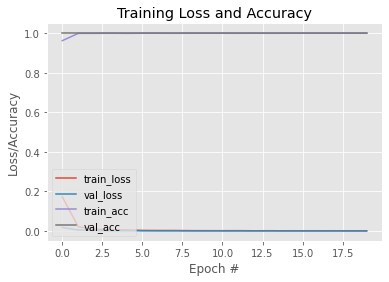

In [5]:
# split training set and validation dataset
(trainX, validationX, trainY, validationY) = train_test_split(dataset, labels, test_size=0.20, stratify=labels, random_state=42)

# split training set and testing dataset
(trainX, testX, trainY, testY) = train_test_split(trainX, trainY, test_size=0.25, random_state=42)

# configure image data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network but do not include the head of fully connected layer
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# define the top model for each layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# combine head fully connected model on top of the base model 
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model so it will NOT update during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile model
print("[INFO] Compiling Model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] Training Head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validationX, validationY),
	validation_steps=len(validationX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] Evaluating Network...")
predIdxs = model.predict(testX, batch_size=BS)

# find the index of label for each of our image in testing set corresponding to its largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# output classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# inspect the accuracy of the model on testing set
print("[INFO] Accuracy...")
print(accuracy_score(testY.argmax(axis=1), predIdxs))

# finalize the model and save
print("[INFO] Saving Model...")
model.save("/content/drive/MyDrive/Fake-person-dataset-model/Fake-person-dataset-model.model", save_format="h5")

# plot grpah to inspect the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/Fake-person-dataset-model/Fake-person-dataset-plot.png")
